# Hoarder SAM Dataset Parser

In [4]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 13.9 MB 33.8 MB/s eta 0:00:01
     |████████████████████████████████| 313 kB 167.8 MB/s eta 0:00:01
     |████████████████████████████████| 220 kB 170.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 169.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 162.2 MB/s eta 0:00:01
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [16]:
from typing import Union

import os
import random

import cv2
import hoarder
import numpy as np
import supervision as sv
import torch

from hoarder.datasets.local_dataset import LocalDataset
from torch.utils.data import Dataset

class HoarderSegmentationDataset(Dataset, LocalDataset):
    def __init__(self, path: Union[str, list], transform=None, eval_ori_resolution=False) -> None:

        # Only for SAM-HQ train dict input
        if isinstance(path, list):
            path = path[0]["im_path"]
        
        super(LocalDataset, self).__init__(hoarder.conservator, path)
        self.dataset_info = self.get_dataset_info()
        self.frames = self.get_frames()
        self.transform = transform
        self.eval_ori_resolution = eval_ori_resolution

        valid_frames = []
        for frame in self.frames:
            if 'annotations' not in frame:
                continue
            if len(frame['annotations']) == 0:
                continue

            if not all(['boundingPolygon' in ann for ann in frame['annotations']]):
                continue

            valid_frames.append(frame)
        self.frames = valid_frames

    def __len__(self) -> int:
        return len(self.frames)

    def __getitem__(self, index: int):
        frame = self.frames[index]
        image_path = self.get_local_image_path(frame)
        im = cv2.imread(image_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_h, im_w = im.shape[:2]

        for _ in range(10):
            ann = random.choice(frame['annotations'])
            if "boundingPolygon" in ann:
                break

        if "boundingPolygon" not in ann:
            raise RuntimeError("Missing Polygon Annotations")

        label = ann["labels"][0]
        polygon = ann["boundingPolygon"]
        polygon = [[data['x'], data['y']] for data in polygon]
        gt = sv.polygon_to_mask(np.asarray(polygon), (im_w,im_h))

        im = torch.tensor(im, dtype=torch.float32)
        im = torch.transpose(torch.transpose(im,1,2),0,1)
        gt = torch.unsqueeze(torch.tensor(gt, dtype=torch.float32),0)

        sample = {
            "imidx": torch.from_numpy(np.array(index)),
            "image": im,
            "label": gt,
            "shape": torch.tensor(im.shape[-2:]),
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [17]:
from torchvision import transforms, utils
from train.utils.dataloader import RandomHFlip, LargeScaleJitter

dataset_dir = "sample_data/TestSAM/"

my_transforms = [
            RandomHFlip(),
            LargeScaleJitter()
            ]

dataset_key = {
    
}

dataset_hoarder = {"name": "TestSAM",
         "im_dir": "./sample_data/TestSAM/",
         "gt_dir": "",
         "im_ext": ".jpg",
         "gt_ext": ".png"
}


# dataset = HoarderSegmentationDataset(path=dataset_dir, transform=transforms.Compose(my_transforms))

dataset = HoarderSegmentationDataset(path=[dataset_hoarder], transform=transforms.Compose(my_transforms))

In [18]:
sample = dataset[0]

In [19]:
sample.keys()

dict_keys(['imidx', 'image', 'label', 'shape'])

In [20]:
sample['imidx'], sample['shape']

(tensor(0), tensor([1024, 1024]))

(1024, 1024, 3)


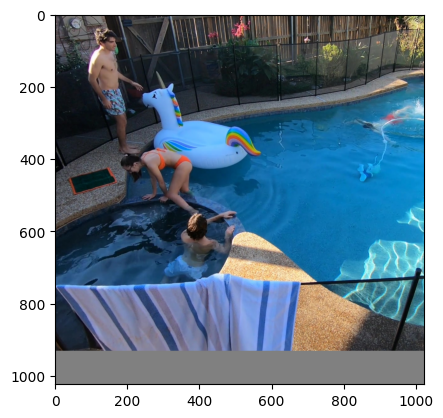

In [21]:
import matplotlib.pyplot as plt

image = sample['image'].detach().cpu().numpy()
image = np.transpose(image, (1,2,0)).astype(np.int32)
print(image.shape)
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

plt.imshow(image)

In [22]:
gt = sample['label'].detach().cpu().numpy()
gt = np.transpose(gt, (1,2,0)).astype(np.int32)
print(gt.shape)

(1024, 1024, 1)


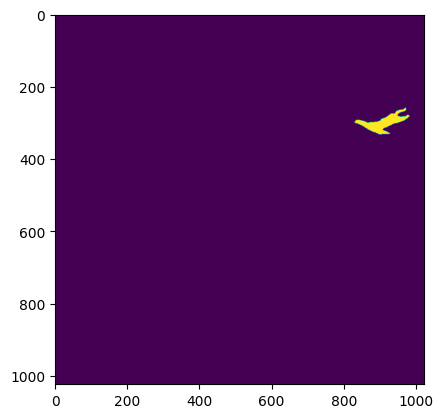

In [23]:
plt.imshow(gt)